In [ ]:
import pandas as pd
import os
from google.colab import drive

# Mount Google Drive
drive.mount('/content/drive')

os.chdir('/content/drive/MyDrive/FYP')

#load original CSV file
df_origin = pd.read_csv('original.csv')
df_origin.head()

Mounted at /content/drive


,Commit ID,Origin Code
0,7ad6162573ba79a4392c63b453ad0220ca6c5ace,"@@ -468,13 +468,12 @@ int _gnutls_ciphertext2c..."
1,055ecbc62878e86287d742c7246c21606cee8183,"@@ -760,7 +760,7 @@ static struct pdo_dbh_meth..."
2,055ecbc62878e86287d742c7246c21606cee8183,"@@ -117,7 +117,7 @@ PHP_METHOD(sqlite3, open)\..."
3,251fc70e9722f931eec23a34030d05ba5f747b0e,"@@ -163,7 +163,8 @@ unpack_Z_stream(int fd_in,..."
4,251fc70e9722f931eec23a34030d05ba5f747b0e,"@@ -0,0 +1,20 @@"


In [ ]:
#load patched CSV file
df_patched = pd.read_csv('patched.csv')
df_patched.head()

,Commit ID,Patched Code
0,7ad6162573ba79a4392c63b453ad0220ca6c5ace,"@@ -468,13 +468,12 @@ int _gnutls_ciphertext2c..."
1,055ecbc62878e86287d742c7246c21606cee8183,"@@ -760,7 +760,7 @@ static struct pdo_dbh_meth..."
2,055ecbc62878e86287d742c7246c21606cee8183,"@@ -117,7 +117,7 @@ PHP_METHOD(sqlite3, open)\..."
3,251fc70e9722f931eec23a34030d05ba5f747b0e,"@@ -163,7 +163,8 @@ unpack_Z_stream(int fd_in,..."
4,251fc70e9722f931eec23a34030d05ba5f747b0e,"@@ -0,0 +1,20 @@\n#!/bin/sh\n# Copyright 2011 ..."


In [ ]:
# Combine the data into a single DataFrame
df_combined = pd.DataFrame({
    'source_code': df_origin['Origin Code'],  # Assuming your original code column is named 'code'
    'target_code': df_patched['Patched Code']  # Assuming your patched code column is named 'code'
})

# Remove rows with any NaN values
df_combined = df_combined.dropna()

# Display the first few rows to ensure the data looks good
df_combined

,source_code,target_code
0,"@@ -468,13 +468,12 @@ int _gnutls_ciphertext2c...","@@ -468,13 +468,12 @@ int _gnutls_ciphertext2c..."
1,"@@ -760,7 +760,7 @@ static struct pdo_dbh_meth...","@@ -760,7 +760,7 @@ static struct pdo_dbh_meth..."
2,"@@ -117,7 +117,7 @@ PHP_METHOD(sqlite3, open)\...","@@ -117,7 +117,7 @@ PHP_METHOD(sqlite3, open)\..."
3,"@@ -163,7 +163,8 @@ unpack_Z_stream(int fd_in,...","@@ -163,7 +163,8 @@ unpack_Z_stream(int fd_in,..."
4,"@@ -0,0 +1,20 @@","@@ -0,0 +1,20 @@\n#!/bin/sh\n# Copyright 2011 ..."
...,...,...
106969,"@@ -178,11 +178,12 @@\nstruct CirrusVGAState;\...","@@ -22,31 +22,65 @@\n* THE SOFTWARE.\n*/\nstat..."
106970,"@@ -22,31 +22,65 @@\n* THE SOFTWARE.\n*/\nstat...","@@ -23,27 +23,29 @@\n*/\n#if DEPTH == 8\n#defi..."
106971,"@@ -23,27 +23,29 @@\n*/\n#if DEPTH == 8\n#defi...","@@ -178,11 +178,12 @@\nstruct CirrusVGAState;\..."
106972,"@@ -178,11 +178,12 @@\nstruct CirrusVGAState;\...","@@ -22,31 +22,65 @@\n* THE SOFTWARE.\n*/\nstat..."


In [ ]:
!pip install -q datasets
!pip install -q transformers
!pip install -q sentencepiece
!pip install -q accelerate -U
!pip install -q scikit-learn
!pip install -q pyarrow==14.0.1 datasets --upgrade
!pip install -q rouge_score

  Preparing metadata (setup.py) ... done


In [ ]:
from datasets import Dataset

# Convert the cleaned DataFrame into a Hugging Face Dataset
dataset = Dataset.from_pandas(df_combined)

# Split the dataset into training and validation sets
train_test_split = dataset.train_test_split(test_size=0.2)
train_dataset = train_test_split['train']
valid_dataset = train_test_split['test']

In [ ]:
from transformers import BartTokenizer, BartForConditionalGeneration

# Load distilBART tokenizer and model
tokenizer = BartTokenizer.from_pretrained('sshleifer/distilbart-cnn-6-6')
model = BartForConditionalGeneration.from_pretrained('sshleifer/distilbart-cnn-6-6')

# Assign the EOS token as the padding token
tokenizer.pad_token = tokenizer.eos_token

#tokenization function
def preprocess_function(examples):
    #tokenize the inputs (vulnerable code)
    model_inputs = tokenizer(examples['source_code'], max_length=512, truncation=True, padding="max_length")

    #tokenize the targets (patched code)
    labels = tokenizer(examples['target_code'], max_length=512, truncation=True, padding="max_length")

    #add labels to model inputs
    labels["input_ids"] = [
        [(label if label != tokenizer.pad_token_id else -100) for label in label_seq]
        for label_seq in labels["input_ids"]
    ]

    #add labels to the model inputs
    model_inputs["labels"] = labels["input_ids"]

    return model_inputs

#preprocess the dataset
tokenized_train_dataset = train_dataset.map(preprocess_function, batched=True, load_from_cache_file=False)
tokenized_valid_dataset = valid_dataset.map(preprocess_function, batched=True, load_from_cache_file=False)

#set format for PyTorch on tokenized dataset
tokenized_train_dataset.set_format(type='torch', columns=['input_ids', 'attention_mask', 'labels'])
tokenized_valid_dataset.set_format(type='torch', columns=['input_ids', 'attention_mask', 'labels'])

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.80k [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


pytorch_model.bin:   0%|          | 0.00/460M [00:00<?, ?B/s]

Map:   0%|          | 0/40000 [00:00<?, ? examples/s]

Map:   0%|          | 0/10000 [00:00<?, ? examples/s]

In [ ]:
from transformers import TrainingArguments, Trainer

#training arguments
training_args = TrainingArguments(
    output_dir="./results",
    evaluation_strategy="epoch",
    learning_rate=5e-5,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=3,
    weight_decay=0.01,
    logging_dir='./logs',
    logging_steps=10,
    save_strategy="no",
    fp16=True
)

#initialize Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_train_dataset,
    eval_dataset=tokenized_valid_dataset,
    tokenizer=tokenizer
)

#start training
trainer.train()

#save the fine-tuned model
trainer.save_model('./results/CodeT5_model_1')

# Evaluate the model
evaluation_results = trainer.evaluate()

/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1525: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/accelerate/accelerator.py:494: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.scaler = torch.cuda.amp.GradScaler(**kwargs)


Epoch,Training Loss,Validation Loss
1,0.347100,0.410717
2,0.299800,0.325234
3,0.259900,0.333848


Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generation parameters: {'max_length': 142, 'min_length': 56, 'early_stopping': True, 'num_beams': 4, 'length_penalty': 2.0, 'no_repeat_ngram_size': 3, 'forced_bos_token_id': 0, 'forced_eos_token_id': 2}


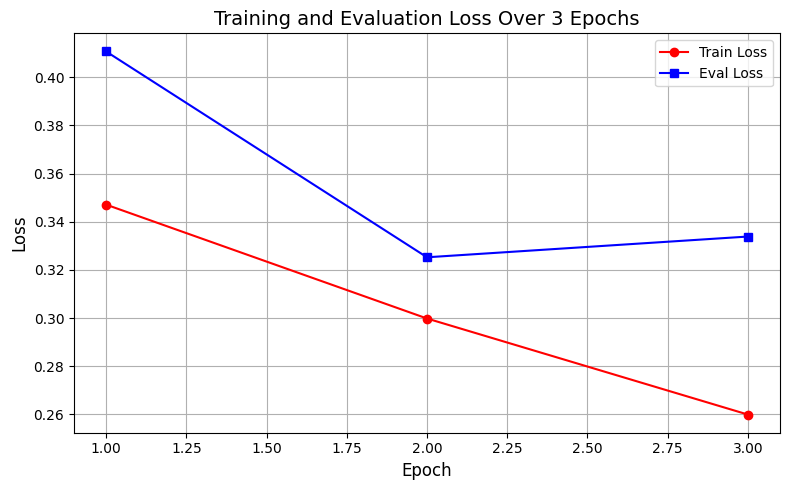

In [2]:
import matplotlib.pyplot as plt

# Data for epochs, training loss, and evaluation loss
epochs = [1, 2, 3]
train_loss = [0.347100, 0.299800, 0.259900]
eval_loss = [0.410717, 0.325234, 0.333848]

# Create figure
plt.figure(figsize=(8, 5))

# Plot training loss
plt.plot(epochs, train_loss, color='red', marker='o', label='Train Loss')

# Plot evaluation loss
plt.plot(epochs, eval_loss, color='blue', marker='s', label='Eval Loss')

# Add labels and title
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Loss', fontsize=12)
plt.title('Training and Evaluation Loss Over 3 Epochs', fontsize=14)

# Add grid and legend
plt.grid(True)
plt.legend()

# Display the plot
plt.tight_layout()
plt.show()

In [ ]:
from datasets import load_metric

#load ROUGE and BLEU metrics
rouge_metric = load_metric("rouge")
bleu_metric = load_metric("bleu")

#define the metric computation function
def compute_metrics(eval_preds):
    logits, labels = eval_preds
    #decode the predictions and labels
    decoded_preds = tokenizer.batch_decode(logits, skip_special_tokens=True)
    decoded_labels = tokenizer.batch_decode(labels, skip_special_tokens=True)

    #Rouge expects a newline after each sentence in decoded_preds/labels
    decoded_preds = ["\n".join(pred.strip() for pred in p.splitlines()) for p in decoded_preds]
    decoded_labels = ["\n".join(label.strip() for label in l.splitlines()) for l in decoded_labels]

    #compute ROUGE scores
    rouge_result = rouge_metric.compute(predictions=decoded_preds, references=decoded_labels)

    #prepare for BLEU - BLEU expects tokenized sentences as lists of lists
    decoded_preds = [pred.split() for pred in decoded_preds]
    decoded_labels = [[label.split()] for label in decoded_labels]  # BLEU requires nested list

    #compute BLEU score
    bleu_result = bleu_metric.compute(predictions=decoded_preds, references=decoded_labels)

    #combine results
    result = {
        "rouge1": rouge_result["rouge1"].mid.fmeasure,
        "rouge2": rouge_result["rouge2"].mid.fmeasure,
        "rougeL": rouge_result["rougeL"].mid.fmeasure,
        "bleu": bleu_result["bleu"]
    }

    return result


/usr/local/lib/python3.10/dist-packages/datasets/load.py:759: FutureWarning: The repository for rouge contains custom code which must be executed to correctly load the metric. You can inspect the repository content at https://raw.githubusercontent.com/huggingface/datasets/2.19.2/metrics/rouge/rouge.py
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this metric from the next major release of `datasets`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/datasets/load.py:759: FutureWarning: The repository for bleu contains custom code which must be executed to correctly load the metric. You can inspect the repository content at https://raw.githubusercontent.com/huggingface/datasets/2.19.2/metrics/bleu/bleu.py
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this metric from the next major r

# learning rate of 3e-5

In [ ]:
model = BartForConditionalGeneration.from_pretrained('./results/CodeT5_model_1')

#training arguments
training_args = TrainingArguments(
    output_dir="./results",
    evaluation_strategy="epoch",
    learning_rate=3e-5,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=3,
    weight_decay=0.01,
    logging_dir='./logs',
    logging_steps=10,
    save_strategy="no",
    fp16=True
)

#initialize Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_train_dataset,
    eval_dataset=tokenized_valid_dataset,
    tokenizer=tokenizer
)

#start training
trainer.train()

#save the fine-tuned model
trainer.save_model('./results/CodeT5_model_2')

# Evaluate the model
evaluation_results = trainer.evaluate()

/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1525: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/accelerate/accelerator.py:494: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.scaler = torch.cuda.amp.GradScaler(**kwargs)


Epoch,Training Loss,Validation Loss
1,0.066100,0.304156
2,0.144100,0.317029
3,0.160000,0.314658


Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generation parameters: {'max_length': 142, 'min_length': 56, 'early_stopping': True, 'num_beams': 4, 'length_penalty': 2.0, 'no_repeat_ngram_size': 3, 'forced_bos_token_id': 0, 'forced_eos_token_id': 2}


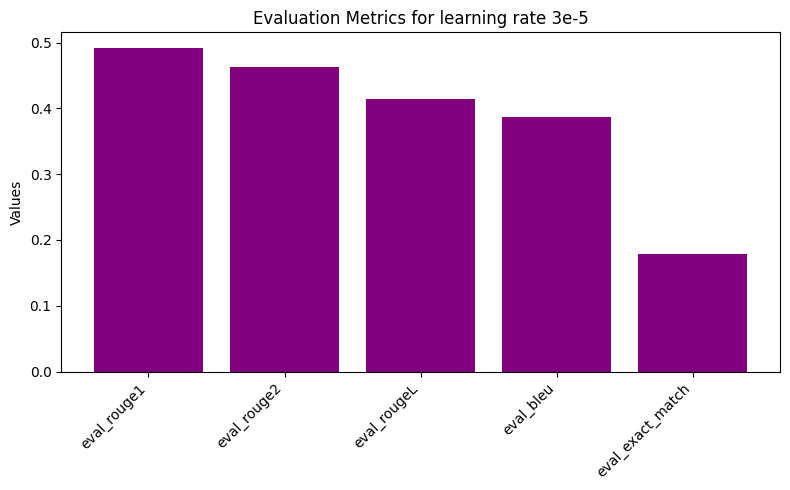

In [3]:
import matplotlib.pyplot as plt
import numpy as np

# Data for both learning rates
metrics = ['eval_rouge1', 'eval_rouge2', 'eval_rougeL', 'eval_bleu', 'eval_exact_match']

# Set width for bars
bar_width = 0.35

# Plotting
plt.figure(figsize=(8, 5))
plt.bar(metrics, values_lr_3e5, color='purple')

# Add labels and title
plt.ylabel('Values')
plt.title('Evaluation Metrics for learning rate 3e-5')
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better readability

# Show the plot
plt.tight_layout()
plt.show()

# Learning rate of 5e-6

In [ ]:
model = BartForConditionalGeneration.from_pretrained('./results/CodeT5_model_2')

#set training arguments
training_args = TrainingArguments(
    output_dir="./results",
    evaluation_strategy="epoch",
    learning_rate=5e-6,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=3,
    weight_decay=0.01,
    logging_dir='./logs',
    logging_steps=10,
    save_strategy="no",
    fp16=True
)

#initialize Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_train_dataset,
    eval_dataset=tokenized_valid_dataset,
    tokenizer=tokenizer
)

#start training
trainer.train()

#save the fine-tuned model
trainer.save_model('./results/CodeT5_model_3')

/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1525: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/accelerate/accelerator.py:494: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.scaler = torch.cuda.amp.GradScaler(**kwargs)


Epoch,Training Loss,Validation Loss
1,0.023800,0.300513
2,0.075300,0.315850
3,0.112200,0.323232


Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generation parameters: {'max_length': 142, 'min_length': 56, 'early_stopping': True, 'num_beams': 4, 'length_penalty': 2.0, 'no_repeat_ngram_size': 3, 'forced_bos_token_id': 0, 'forced_eos_token_id': 2}


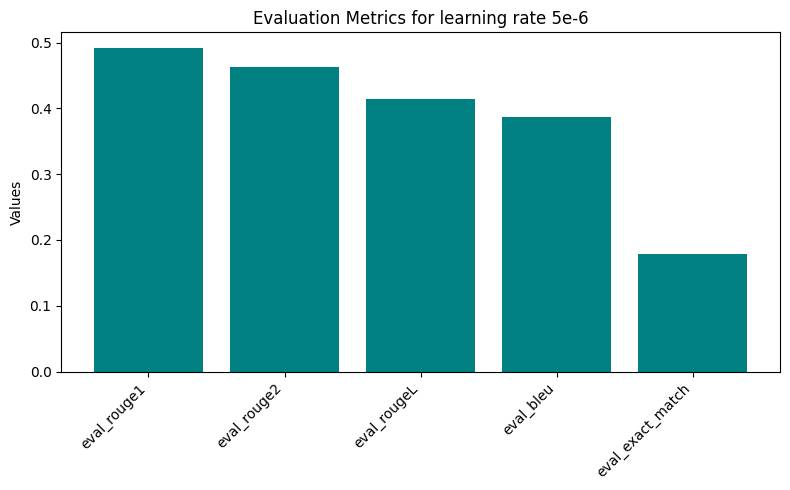

In [4]:
import matplotlib.pyplot as plt
import numpy as np

# Data for both learning rates
metrics = ['eval_rouge1', 'eval_rouge2', 'eval_rougeL', 'eval_bleu', 'eval_exact_match']

# Set width for bars
bar_width = 0.35

# Plotting
plt.figure(figsize=(8, 5))
plt.bar(metrics, values_lr_3e5, color='teal')

# Add labels and title
plt.ylabel('Values')
plt.title('Evaluation Metrics for learning rate 5e-6')
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better readability

# Show the plot
plt.tight_layout()
plt.show()